In [1]:
import dataset_loader
import util

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"
# DATASET_ROOT = "../../sabana/dataset/newbie-dataset"

In [3]:
SLICE_DURATION = 5 # sec
EXPANSION_RATE = 2.0
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 1
SETTLE_FRAME = 10

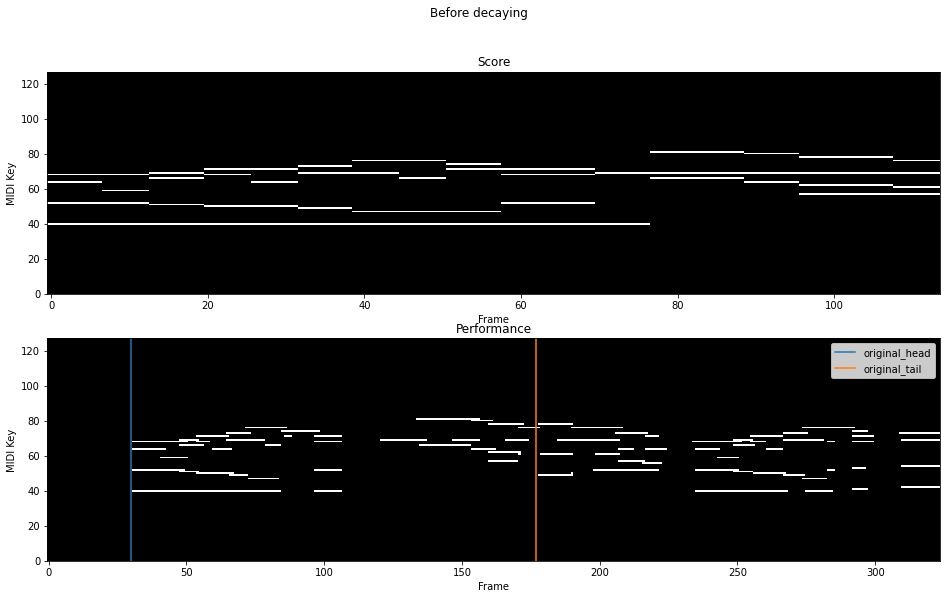

<Figure size 432x288 with 0 Axes>

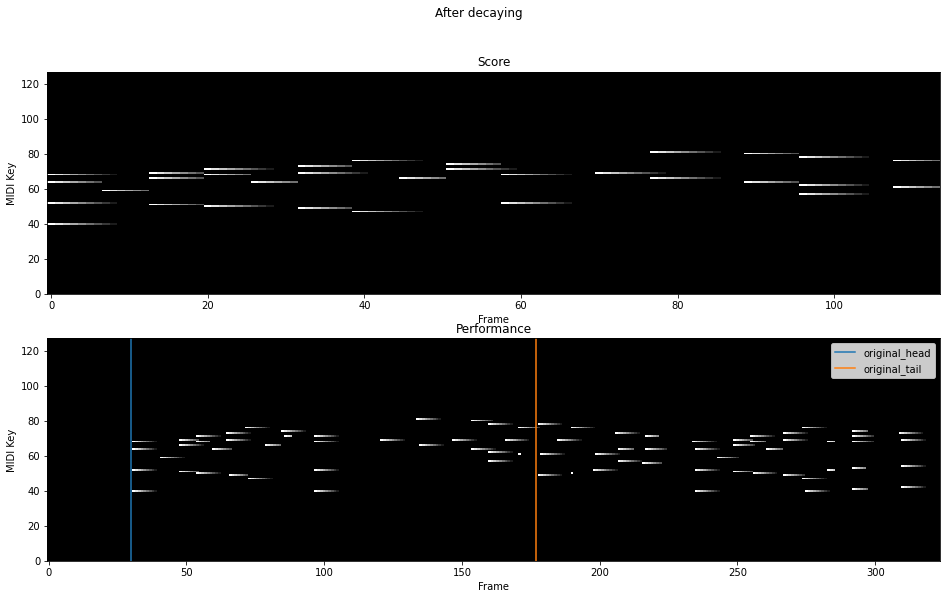

<Figure size 432x288 with 0 Axes>

In [4]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, slice_duration=SLICE_DURATION, expansion_rate=EXPANSION_RATE, frame_per_second=FRAME_PER_SECOND, shuffle=True)

for idx in range(NUM_SAMPLES):
    score, perf, alignment = gen.__next__()
    util.plot_midi_matrices(score, perf, alignment, title="Before decaying")
    score = util.process_decay_to_midi_matrix(score, SETTLE_FRAME)
    perf = util.process_decay_to_midi_matrix(perf, SETTLE_FRAME)
    util.plot_midi_matrices(score, perf, alignment, title="After decaying")